# Explore our current setup

In [2]:
## The load_dataset function from morning 1
import tensorflow as tf

def load_dataset(path_to_file:str):
    """
    :return: dataset, ids_from_chars, chars_from_ids
    """
    text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
    vocab = sorted(set(text))
    ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
    chars_from_ids = tf.keras.layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)
    all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
    print(all_ids)
    print(len(all_ids))
    ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
    seq_length = 100
    sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
    def split_input_target(sequence):
        input_text = sequence[:-1]
        target_text = sequence[1:]
        return input_text, target_text
    dataset = sequences.map(split_input_target)
    return (dataset, ids_from_chars, chars_from_ids)


In [3]:
data_file = "./Logic_lyrics.txt"
dataset, ids_from_chars, chars_from_ids = load_dataset(data_file)
ids_from_chars.vocabulary_size()

tf.Tensor([ 1 35  6 ...  2 64 56], shape=(218297,), dtype=int64)
218297


89

# Exploring the char -> int and int -> char functions

In [4]:
input_string = "Hello world (^)"
# Encode
input_ids = ids_from_chars(list(input_string))
# Decode
out_chars = chars_from_ids(input_ids)
output_string = tf.strings.join(out_chars).numpy().decode("utf-8")
print(f"Output: {output_string}")


Output: Hello world ([UNK])


In [5]:
class BasicRNN(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [6]:
EMBED_DIMENSION = 2
RNN_UNITS = 10
basic_rnn = BasicRNN(ids_from_chars.vocabulary_size(), EMBED_DIMENSION, RNN_UNITS)


In [7]:
input_string = "abcdefghijklmnopqrstuvwxyz "
input_chars = tf.strings.unicode_split(["abcdefghijklmnopqrstuvwxyz "], 'UTF-8')
input_ids = ids_from_chars(input_chars).to_tensor()
prefit_embeddings = basic_rnn.embedding(input_ids)
print(prefit_embeddings)



tf.Tensor(
[[[-0.00806743 -0.01156675]
  [-0.01423188 -0.03671377]
  [ 0.02227216 -0.00400728]
  [ 0.04716661  0.01281139]
  [-0.00817358  0.01857752]
  [-0.0243546  -0.02788756]
  [-0.04170684 -0.02782755]
  [ 0.00968965 -0.03696685]
  [ 0.00701566  0.04616747]
  [-0.0036     -0.03829409]
  [ 0.03765232  0.03805855]
  [-0.02151852  0.00031354]
  [ 0.00586755  0.03748995]
  [ 0.01514896 -0.04163245]
  [-0.0298542  -0.03149854]
  [-0.00926827  0.02004662]
  [-0.0074075  -0.00748467]
  [ 0.03778824 -0.04488046]
  [ 0.00410046  0.03615079]
  [ 0.03093486 -0.03341848]
  [-0.02300145  0.02480233]
  [ 0.02331254 -0.00275707]
  [-0.03134834  0.0208005 ]
  [-0.01131744 -0.04786881]
  [ 0.02246536  0.01523687]
  [-0.04240207  0.00489021]
  [ 0.0367419  -0.03191682]]], shape=(1, 27, 2), dtype=float32)


In [8]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
basic_rnn.compile(optimizer='adam', loss=loss)

In [9]:
def create_training_batches(dataset, batch_size = 64, buffer_size = 1000):
    # Buffer size to shuffle the dataset
    # (TF data is designed to work with possibly infinite sequences,
    # so it doesn't attempt to shuffle the entire sequence in memory. Instead,
    # it maintains a buffer in which it shuffles elements).
    return (dataset
        .shuffle(buffer_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE))
train_batches = create_training_batches(dataset)
basic_rnn.fit(train_batches, epochs=100)

Epoch 1/100


2023-03-31 21:49:28.253092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [218297]
	 [[{{node Placeholder/_0}}]]
2023-03-31 21:49:28.254574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [218297]
	 [[{{node Placeholder/_0}}]]
2023-03-31 21:49:28.581415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

33/33 [==============================] - 2s 21ms/step - loss: 4.4500
Epoch 2/100
33/33 [==============================] - 1s 17ms/step - loss: 4.2447
Epoch 3/100
33/33 [==============================] - 1s 19ms/step - loss: 3.6563
Epoch 4/100
33/33 [==============================] - 1s 18ms/step - loss: 3.3186
Epoch 5/100
33/33 [==============================] - 1s 19ms/step - loss: 3.2439
Epoch 6/100
33/33 [==============================] - 1s 19ms/step - loss: 3.2168
Epoch 7/100
33/33 [==============================] - 1s 17ms/step - loss: 3.2035
Epoch 8/100
33/33 [==============================] - 1s 19ms/step - loss: 3.1968
Epoch 9/100
33/33 [==============================] - 1s 18ms/step - loss: 3.1922
Epoch 10/100
33/33 [==============================] - 1s 17ms/step - loss: 3.1875
Epoch 11/100
33/33 [==============================] - 1s 17ms/step - loss: 3.1853
Epoch 12/100
33/33 [==============================] - 1s 17ms/step - loss: 3.1835
Epoch 13/100
33/33 [=================

In [10]:
# Checkout the embeddings generated after the basic_rnn was fit
postfit_embeddings = basic_rnn.embedding(input_ids)

# Visualize the fit embedding layer

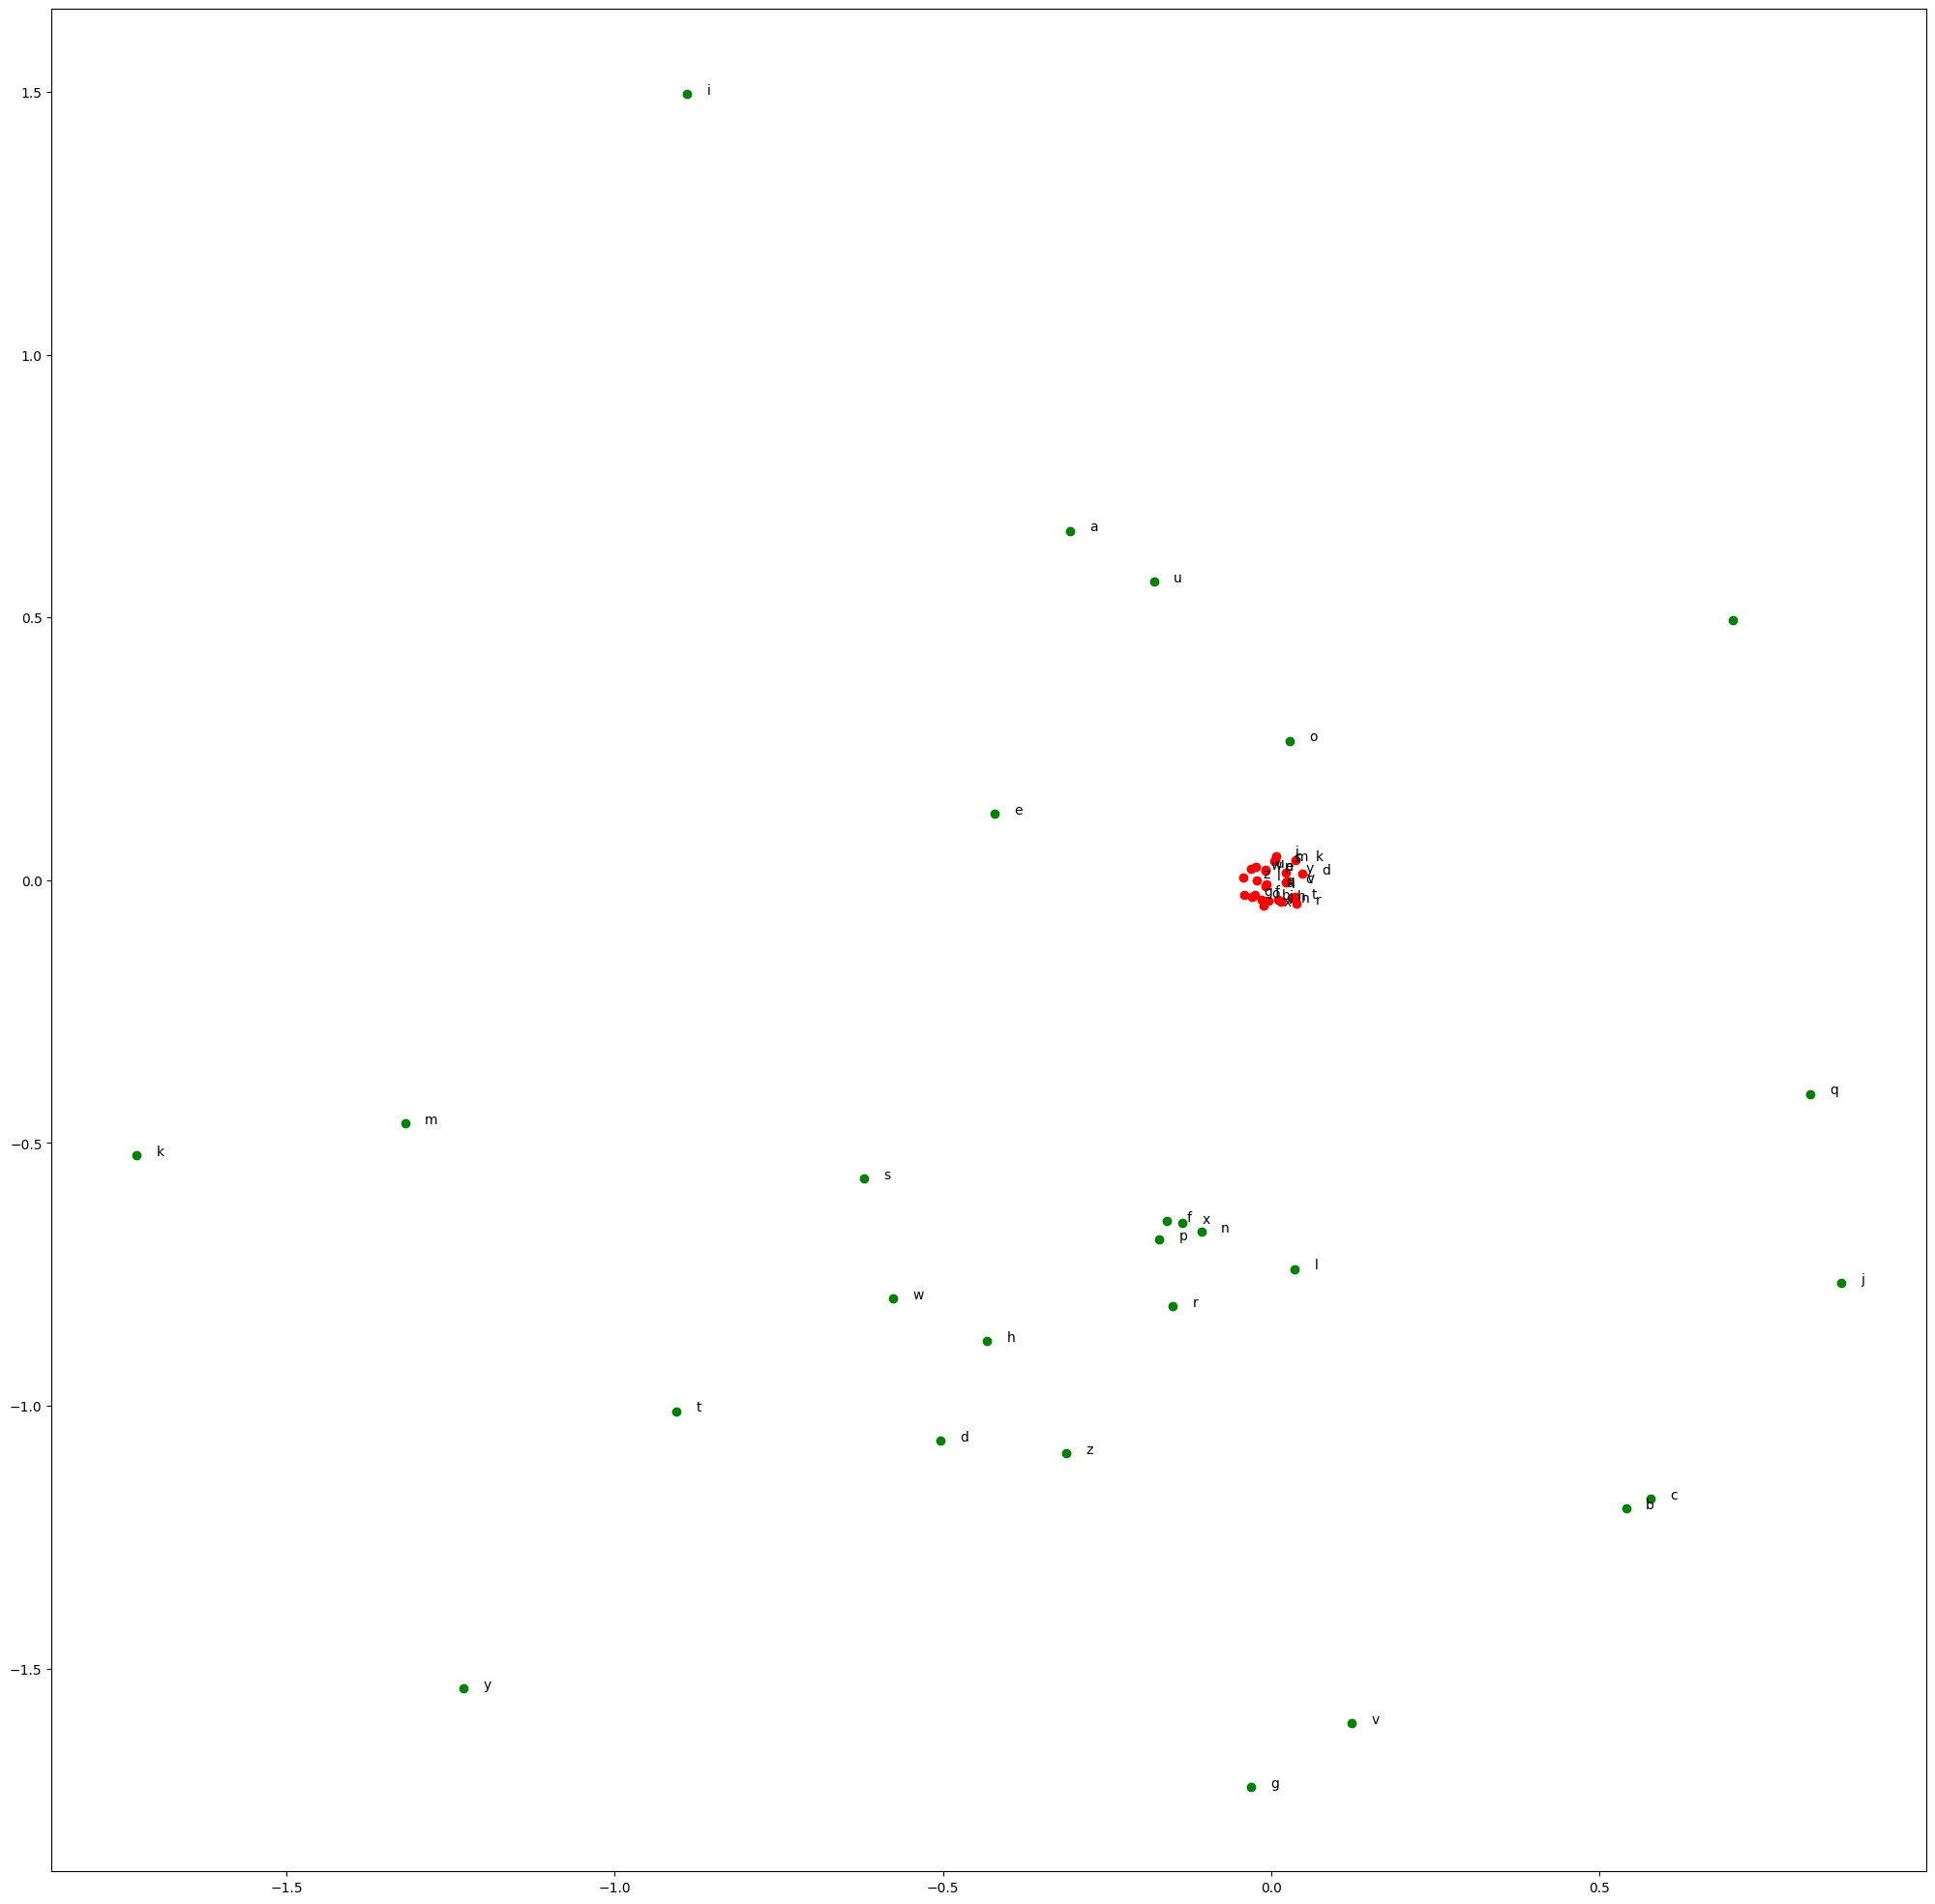

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(25,25))

# Data
postfit_embed_data = np.array(postfit_embeddings)[0]
prefit_embed_data = np.array(prefit_embeddings)[0]
plt.scatter(postfit_embed_data[:,0], postfit_embed_data[:,1], c="g")
plt.scatter(prefit_embed_data[:,0], prefit_embed_data[:,1], c="r")

# Annotations
input_chars = np.array(list(input_string))
for (idx,(x,y)) in enumerate(postfit_embed_data):
    plt.text(x=x+.03, y = y, s = input_chars[idx])
for (idx,(x,y)) in enumerate(prefit_embed_data):
    plt.text(x=x+.03, y = y, s = input_chars[idx])
plt.show()

# Lets get BETTER at text generation

## Gameplan: Token Exploration
1. Change from using characters as tokens to words as tokens
2. Use subwords insteads of words

sentence --<Tokenizier>--> tokens --<EmbeddingLayer>--> embedding --

In [12]:
# Word Based Tokenizers

from transformers import BertTokenizer

def load_word_dataset(path_to_file:str):
    """
    :return: dataset, tokenizer
    """
    text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
    text = text.replace("\n"," ")
    print(text)
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    text_encodings = []
    chunk_size = 512
    cur_idx = 0
    while cur_idx < len(text):
        text_encodings.extend(tokenizer.encode(text[cur_idx:cur_idx+chunk_size]))
        cur_idx += chunk_size
    ids_dataset = tf.data.Dataset.from_tensor_slices(text_encodings)
    seq_length = 100
    sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
    def split_input_target(sequence):
        input_text = sequence[:-1]
        target_text = sequence[1:]
        return input_text, target_text
    dataset = sequences.map(split_input_target)
    return (dataset, tokenizer)

(dataset, tokenizer) = load_word_dataset("./Logic_lyrics.txt")

/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 I've been on the low I been taking my time I feel like I'm out of my mind It feel like my life ain't mine (Who can relate? Woo!) I've been on the low I been taking my time I feel like I'm out of my mind It feel like my life ain't mine  I don't wanna be alive I don't wanna be alive I just wanna die today I just wanna die I don't wanna be alive I don't wanna be alive I just wanna die And let me tell you why  All this other shit I'm talkin' 'bout they think they know it I've been praying for somebody to save me, no one's heroic And my life don't even matter, I know it, I know it I know I'm hurting deep down but can't show it I never had a place to call my own I never had a home, ain't nobody callin' my phone Where you been? Where you at? What's on your mind? They say every life precious but nobody care about mine  I've been on the low I been taking my time I feel like I'm out of my mind It feel like my life ain't mine (Who can relate? Woo!) I've been on the low I been taking my time I fe

In [13]:
print(dataset)
print(len(tokenizer.vocab))

<_MapDataset element_spec=(TensorSpec(shape=(100,), dtype=tf.int32, name=None), TensorSpec(shape=(100,), dtype=tf.int32, name=None))>
30522


In [14]:
bert_tkns_rnn = BasicRNN(len(tokenizer.vocab), EMBED_DIMENSION, RNN_UNITS)
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
bert_tkns_rnn.compile(optimizer='adam', loss=loss)

In [15]:
train_batches = create_training_batches(dataset)
bert_tkns_rnn.fit(train_batches, epochs=30)

Epoch 1/30


2023-03-31 21:50:46.685999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [57746]
	 [[{{node Placeholder/_0}}]]
2023-03-31 21:50:46.686493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [57746]
	 [[{{node Placeholder/_0}}]]
2023-03-31 21:50:46.843483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

8/8 [==============================] - 7s 752ms/step - loss: 10.3204
Epoch 2/30
8/8 [==============================] - 6s 769ms/step - loss: 10.3053
Epoch 3/30
8/8 [==============================] - 6s 763ms/step - loss: 10.2870
Epoch 4/30
8/8 [==============================] - 6s 761ms/step - loss: 10.2628
Epoch 5/30
8/8 [==============================] - 6s 765ms/step - loss: 10.2294
Epoch 6/30
8/8 [==============================] - 6s 776ms/step - loss: 10.1816
Epoch 7/30
8/8 [==============================] - 6s 765ms/step - loss: 10.1121
Epoch 8/30
8/8 [==============================] - 7s 922ms/step - loss: 10.0086
Epoch 9/30
8/8 [==============================] - 6s 785ms/step - loss: 9.8503
Epoch 10/30
8/8 [==============================] - 6s 777ms/step - loss: 9.6090
Epoch 11/30
8/8 [==============================] - 6s 789ms/step - loss: 9.2831
Epoch 12/30
8/8 [==============================] - 6s 787ms/step - loss: 8.9239
Epoch 13/30
8/8 [==============================] - 6

In [21]:
sentence = "The dog is next to the cat. The frog knows the king and the queen"
tokens = tokenizer.encode(sentence)
embeddings = bert_tkns_rnn.embedding(np.array(tokens))
print(np.array(embeddings)[0])
for (idx, (x,y)) in enumerate(np.array(embeddings)):
    print(f"{tokenizer.convert_ids_to_tokens(tokens[idx])}: {x},{y}")

[-0.23048316 -0.2206501 ]
[CLS]: -0.23048315942287445,-0.2206501066684723
the: -0.24837541580200195,-0.20858487486839294
dog: -0.11617211997509003,-0.09184686839580536
is: -0.19933074712753296,-0.24032723903656006
next: -0.1452999860048294,-0.180185928940773
to: -0.15267188847064972,-0.19189772009849548
the: -0.24837541580200195,-0.20858487486839294
cat: -0.010876011103391647,0.04330800846219063
.: -0.1733284443616867,-0.22584784030914307
the: -0.24837541580200195,-0.20858487486839294
frog: 0.04717257246375084,0.04672065004706383
knows: -0.09225583076477051,-0.06180760636925697
the: -0.24837541580200195,-0.20858487486839294
king: -0.17465808987617493,-0.1863059401512146
and: -0.2448635846376419,-0.21002773940563202
the: -0.24837541580200195,-0.20858487486839294
queen: -0.042057886719703674,-0.0728888139128685
[SEP]: -0.1922539323568344,-0.21832755208015442


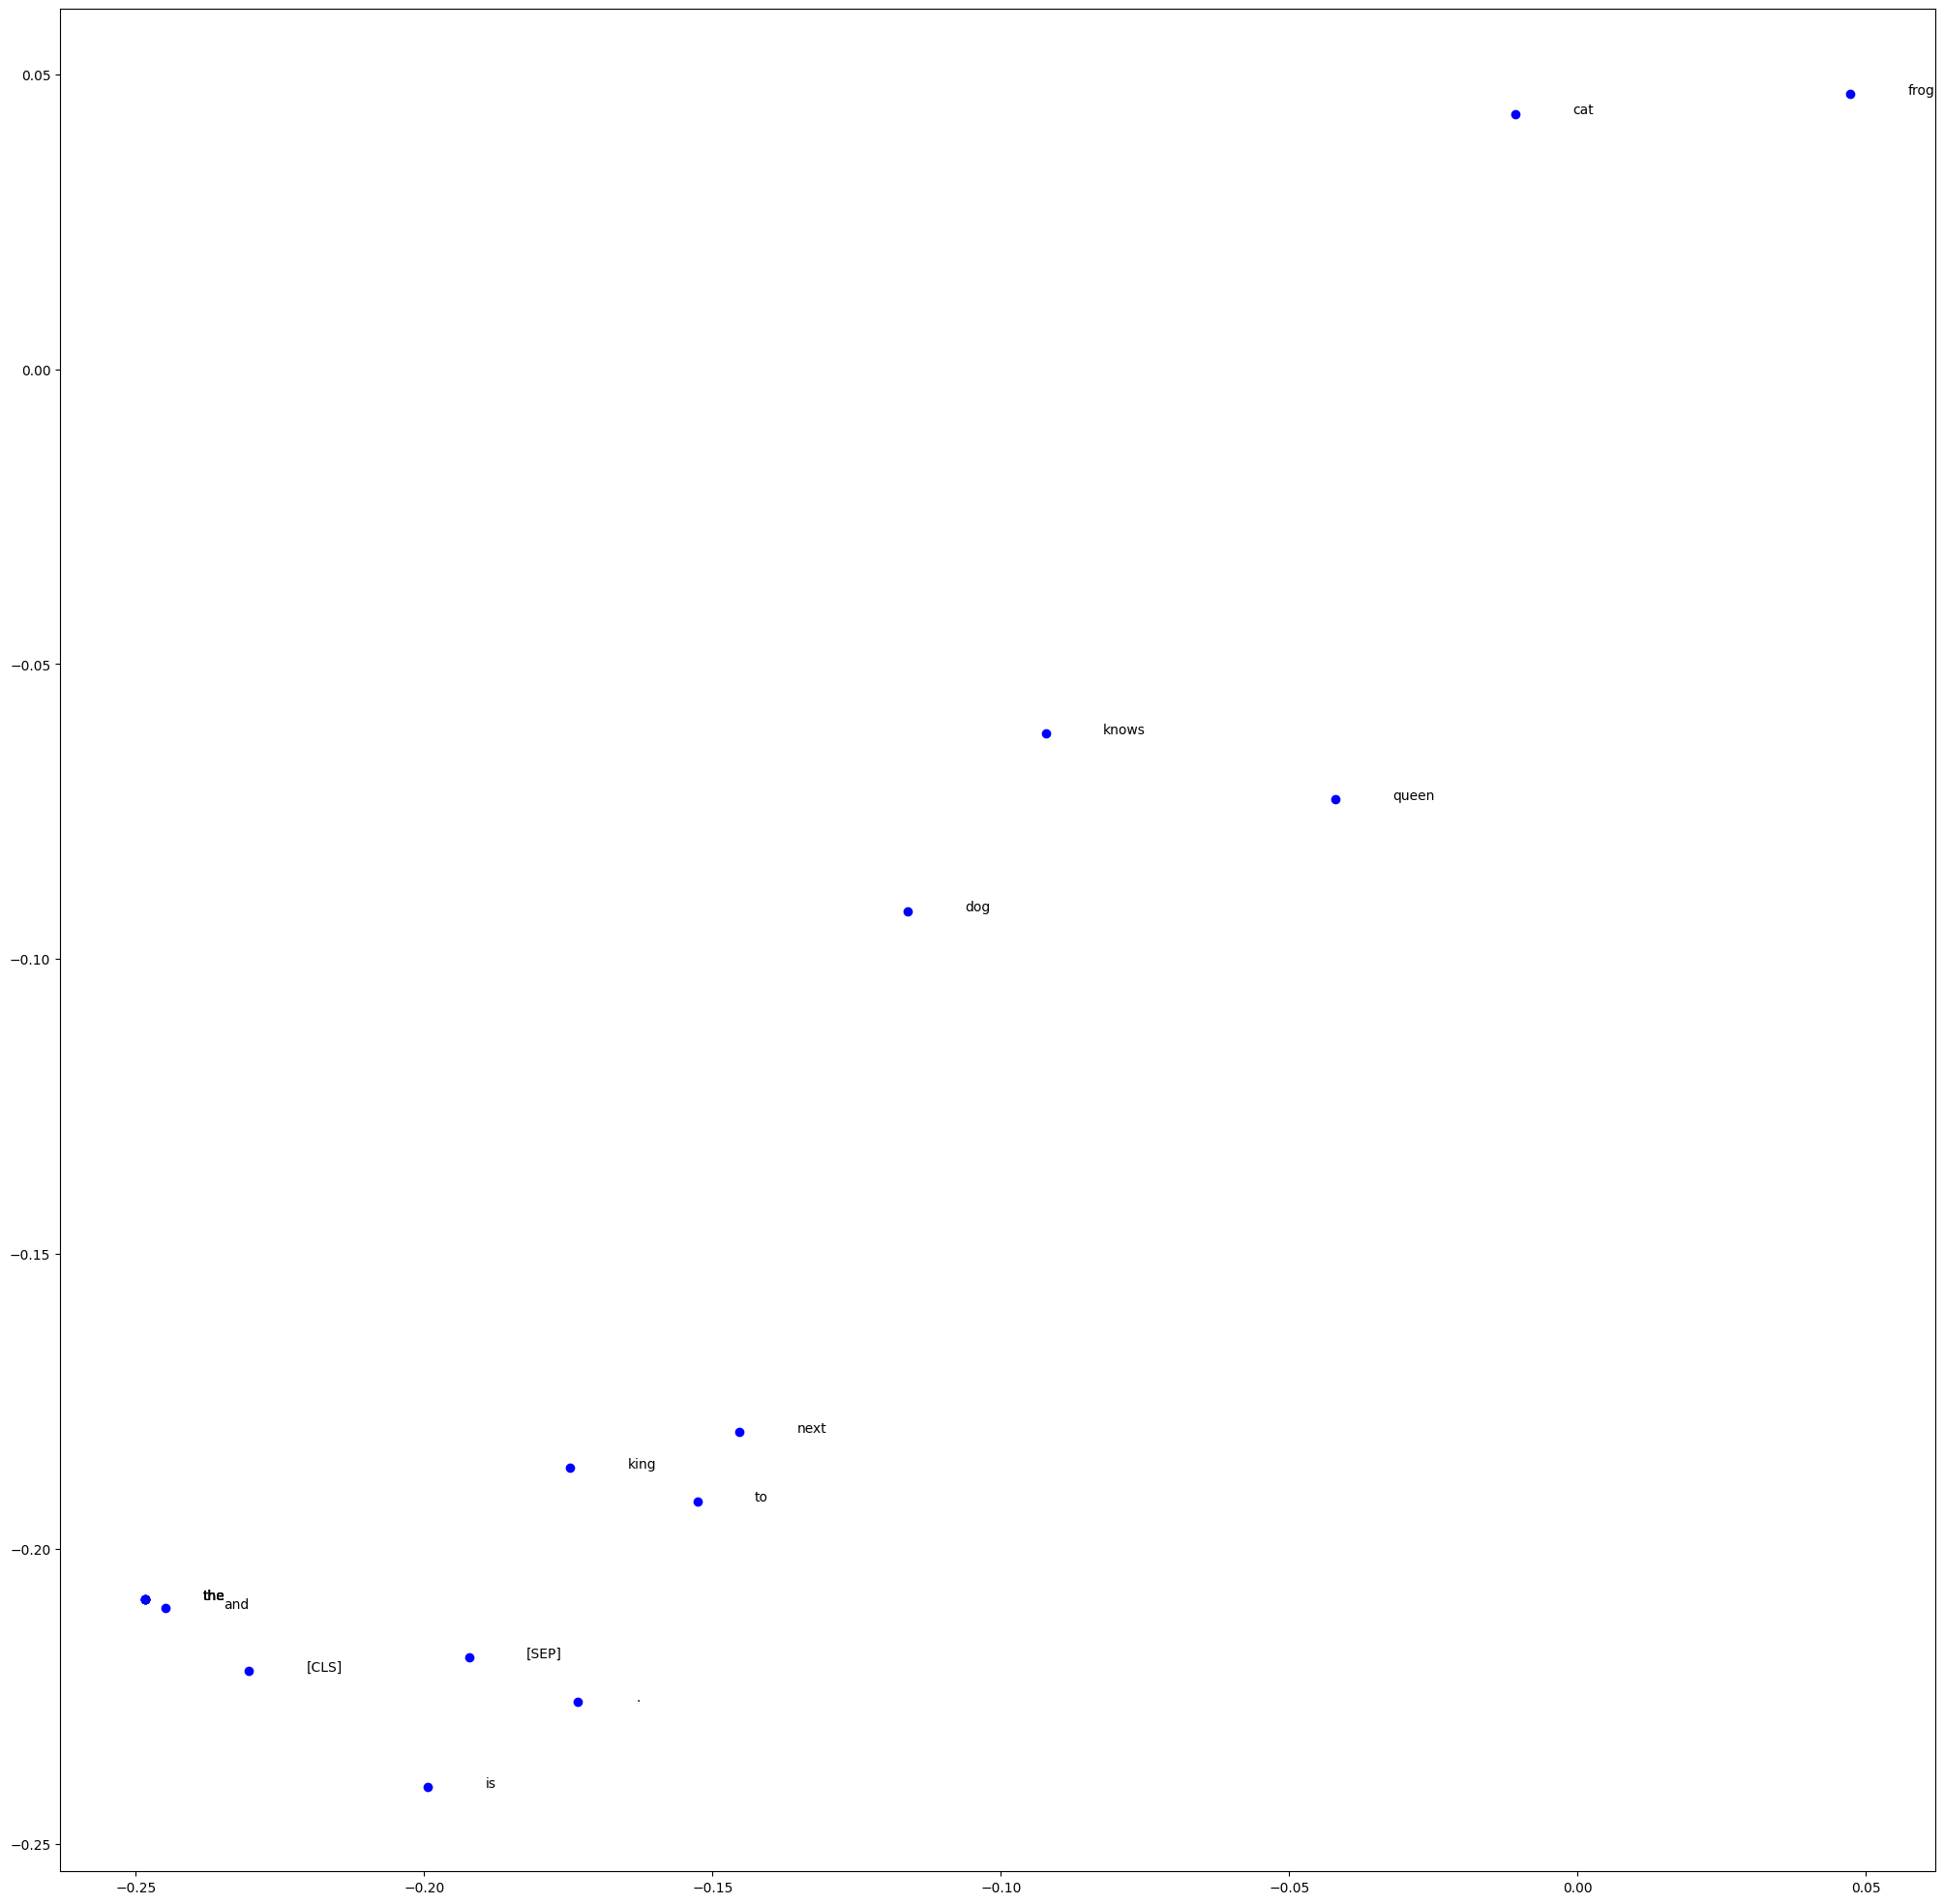

In [22]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(25,25))

# Data
bert_embed_data = np.array(embeddings)
plt.scatter(bert_embed_data[:,0], bert_embed_data[:,1], c="b")
# Annotations
for (idx,(x,y)) in enumerate(bert_embed_data):
    plt.text(x=x+.01, y = y, s = tokenizer.convert_ids_to_tokens(tokens[idx]))
plt.show()

In [23]:
class OneStep(tf.keras.Model):
  def __init__(self, model, encoder_func, decoder_func, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.encode = encoder_func
    self.decode = decoder_func

    # Create a mask to prevent "[UNK]" from being generated.
    # skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    # sparse_mask = tf.SparseTensor(
    #     # Put a -inf at each bad index.
    #     values=[-float('inf')]*len(skip_ids),
    #     indices=skip_ids,
    #     # Match the shape to the vocabulary
    #     dense_shape=[len(ids_from_chars.get_vocabulary())])
    # self.prediction_mask = tf.sparse.to_dense(sparse_mask)
  
  @tf.function(input_signature=[tf.TensorSpec(shape=[1], dtype=tf.string)])
  def get_initial_state(self, inputs):
    """Generate initial state for the GRU layer"""
    return tf.zeros(shape=(1,RNN_UNITS), dtype=tf.float32)

  @tf.function(input_signature=[tf.TensorSpec(shape=[1], dtype=tf.string), tf.TensorSpec(shape=(1, RNN_UNITS), dtype=tf.float32)])
  def generate_one_step(self, inputs, states=None):
    print(inputs)
    print(self.encode(inputs))
    # Convert strings to token IDs.
    # input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.encode(inputs)
    print(input_ids)

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    # predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to words
    predicted_words = self.chars_from_ids(predicted_ids)

    # Return the words and model state.
    return predicted_words, states

word_one_step = OneStep(bert_tkns_rnn, tokenizer.encode, tokenizer.convert_ids_to_tokens)


In [24]:
hw_enc = (tokenizer.encode("hello world"))
print(hw_enc)
tkns = tokenizer.convert_ids_to_tokens(hw_enc)
print(tkns)
next_word = ['She hit the world from the logo']
states = word_one_step.get_initial_state(next_word)
print(word_one_step.model(inputs=input_ids, states=states,
                                          return_state=True))
print(f"States: {states}[{type(states)}]")
result = [next_word]
print(f"Encoding: {tokenizer.encode(next_word)}")
for n in range(10):
    print(type(states))
    next_word, states = word_one_step.generate_one_step(next_word, states=states)
    result.append(next_word)
    print("-"*64)
    print(result)

[101, 7592, 2088, 102]
['[CLS]', 'hello', 'world', '[SEP]']
(<tf.Tensor: shape=(1, 27, 30522), dtype=float32, numpy=
array([[[-0.71525776, -0.7141387 , -0.71787506, ..., -0.7186093 ,
         -0.71783257, -0.71709377],
        [-1.4483156 , -1.4486363 , -1.4560084 , ..., -1.4576654 ,
         -1.4575415 , -1.4523695 ],
        [-2.2588859 , -2.2598917 , -2.2710645 , ..., -2.2743895 ,
         -2.275433  , -2.2649477 ],
        ...,
        [-2.8141747 , -2.813165  , -2.8284943 , ..., -2.8338146 ,
         -2.8352494 , -2.8225222 ],
        [-2.8138552 , -2.8128524 , -2.8281782 , ..., -2.8334947 ,
         -2.8349345 , -2.8222153 ],
        [-2.814154  , -2.8131444 , -2.828473  , ..., -2.8337936 ,
         -2.835232  , -2.8225224 ]]], dtype=float32)>, <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.98528355,  0.98026127, -0.99040604,  0.949592  ,  0.96487844,
         0.9856057 ,  0.9729313 ,  0.99186873, -0.97983646, -0.99030125]],
      dtype=float32)>)
States: [[0. 0. 0. 

ValueError: in user code:

    File "/var/folders/7y/1jp5fzbs05q03xszr7zmwvqw0000gn/T/ipykernel_13484/349297970.py", line 27, in generate_one_step  *
        print(self.encode(inputs))
    File "/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/transformers/tokenization_utils_base.py", line 2301, in encode  *
        encoded_inputs = self.encode_plus(
    File "/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/transformers/tokenization_utils_base.py", line 2727, in encode_plus  *
        **kwargs,
    File "/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/transformers/tokenization_utils.py", line 635, in get_input_ids  *
        raise ValueError(

    ValueError: Input Tensor("inputs:0", shape=(1,), dtype=string) is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
